Please, use Keras with **Tensorflow backend**. If you\'re using Keras with Theano backend, be aware of issue of channels first

### Imports

In [1]:
from keras.models import Sequential
from keras.layers.core import Dropout, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from datetime import datetime

### Load CIFAR-10 dataset

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape) 

(((50000, 32, 32, 3), (50000, 1)), ((10000, 32, 32, 3), (10000, 1)))

In [5]:
label_encoder = {
        0:"airplane",
        1:"automobile",
        2:"bird",
        3:"cat",
        4:"deer",
        5:"dog",
        6:"frog",
        7:"horse",
        8:"ship",
        9:"truck"
}

In [6]:
def get_labels(labels_dict, dict_key):
    return labels_dict[int(dict_key)]

In [7]:
def plot_images(label_names, true_data=(X_train, y_train), y_pred=None):

    X, y = true_data
    num_pics = 9
    indices = np.random.randint(X.shape[0], size=num_pics)

    
    if y_pred is not None and len(y_pred) == len(y):
        acc_rate = (y == y_pred).sum() / len(y_pred)
        plt.figure(figsize=(9,8)).suptitle(f'accuracy: {acc_rate}%')
    else:
        plt.figure(figsize=(8,8))

    for i in range(num_pics):
        
        plt.subplot(331 + i)
        plt.subplots_adjust(hspace=0.7, wspace=2.1)
        if y_pred is not None and len(y_pred) == len(y):
            awesome_title = f'True: {get_labels(label_names, y[indices[i]])}\nPredicted: {get_labels(label_names, y_pred[indices[i]])}'
            plt.title(awesome_title, fontsize=14)
        else:
            plt.title(get_labels(label_names, y[indices[i]]), fontsize=16)
        plt.imshow(X[indices[i]])
    
    return plt.show()
        
    
    
        

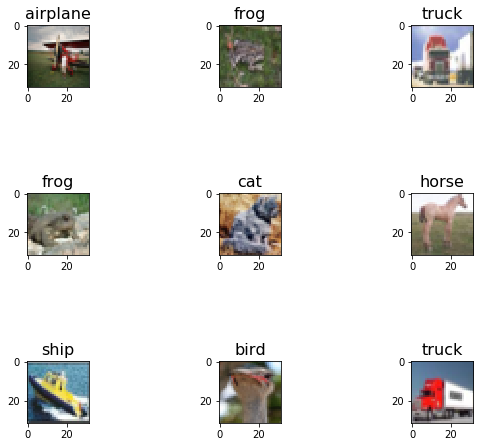

In [8]:
plot_images(label_encoder)

### Data preprocessing

Normalize images ([0...255] ---> [0...1])

In [9]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

Convert labels to one-hot encoding

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Build the model with Keras

### <center> VGGNet model architecture</center>
|  Layer  | Output size  | Filter size / stride |
|:--------|:-------------|:---------------------|
| INPUT   | 32 x 32 x 3  |${~~~~~~~~~~~~~~~~~~}$|
|  CONV   | 32 x 32 x 32 | 3 x 3, K = 32        |
| ACT     | 32 x 32 x 32 |${~~~~~~~~~~~~~~~~~~}$|
| BN      | 32 x 32 x 32 |${~~~~~~~~~~~~~~~~~~}$|
|  CONV   | 32 x 32 x 32 | 3 x 3, K = 32        |
| ACT     | 32 x 32 x 32 |${~~~~~~~~~~~~~~~~~~}$|
| BN      | 32 x 32 x 32 |${~~~~~~~~~~~~~~~~~~}$|
| POOL    | 16 x 16 x 32 |    2 x 2             |
| DROPOUT | 16 x 16 x 32 |${~~~~~~~~~~~~~~~~~~}$|
|  CONV   | 16 x 16 x 64 | 3 x 3, K = 64        |
| ACT     | 16 x 16 x 64 |${~~~~~~~~~~~~~~~~~~}$|
| BN      | 16 x 16 x 64 |${~~~~~~~~~~~~~~~~~~}$|
|  CONV   | 16 x 16 x 64 | 3 x 3, K = 64        |
| ACT     | 16 x 16 x 64 |${~~~~~~~~~~~~~~~~~~}$|
| BN      | 16 x 16 x 64 |${~~~~~~~~~~~~~~~~~~}$|
| POOL    |  8 x  8 x 64 |    2 x 2             |
| DROPOUT |  8 x  8 x 64 |${~~~~~~~~~~~~~~~~~~}$|
| FC      |  512         |${~~~~~~~~~~~~~~~~~~}$|
| ACT     |  512         |${~~~~~~~~~~~~~~~~~~}$|
| BN      |  512         |${~~~~~~~~~~~~~~~~~~}$|
| DROPOUT |  512         |${~~~~~~~~~~~~~~~~~~}$|
| FC      |  10          |${~~~~~~~~~~~~~~~~~~}$|
| SOFTMAX |  10          |${~~~~~~~~~~~~~~~~~~}$|


In [11]:
model = Sequential()
# Conv layer with 32 filters
model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
# Conv layer with 32 filters
model.add(Conv2D(32, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
# 2 x 2 max pooling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Conv layer with 64 filters
model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
# Conv layer with 64 filters
model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
# 2 x 2 max pooling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Fully-connected layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
# Output
model.add(Dropout(0.5))
model.add(Dense(10))

model.add(Activation("softmax"))

### Compile and train the model

> My training (100 epochs) has lasted ~20 minutes for the model with batch normalization and ~15 minutes for the same model without batch normalization on Nvidia GeForce GTX 1060 GPU with CUDA 9.0 installed. That's why I recommend to lower the number of epochs to 50 or even 40.

In [12]:
batch_size = 64
alpha = 0.01
num_epochs = 60
verbose = 1
start_ckpt = datetime.now()

This model is using batch normalization (BN), which slows down the speed of the training

In [13]:
optimizer = SGD(lr=alpha, decay=0.00025, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)
train_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=num_epochs)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 13s 269us/step - loss: 1.6414 - acc: 0.4495 - val_loss: 1.2849 - val_acc: 0.5432
Epoch 2/100
50000/50000 [==============================] - 12s 237us/step - loss: 1.1799 - acc: 0.5902 - val_loss: 0.9792 - val_acc: 0.6560
Epoch 3/100
50000/50000 [==============================] - 12s 243us/step - loss: 0.9812 - acc: 0.6544 - val_loss: 0.8526 - val_acc: 0.7022
Epoch 4/100
50000/50000 [==============================] - 12s 243us/step - loss: 0.8635 - acc: 0.6969 - val_loss: 0.7638 - val_acc: 0.7359
Epoch 5/100
50000/50000 [==============================] - 12s 237us/step - loss: 0.7885 - acc: 0.7221 - val_loss: 0.7325 - val_acc: 0.7467
Epoch 6/100
50000/50000 [==============================] - 12s 240us/step - loss: 0.7352 - acc: 0.7415 - val_loss: 0.7157 - val_acc: 0.7507
Epoch 7/100
50000/50000 [==============================] - 12s 236us/step - loss: 0.6850 - acc: 0.7590 - val_l

Epoch 59/100
50000/50000 [==============================] - 11s 227us/step - loss: 0.1927 - acc: 0.9310 - val_loss: 0.5787 - val_acc: 0.8273
Epoch 60/100
50000/50000 [==============================] - 11s 225us/step - loss: 0.1929 - acc: 0.9309 - val_loss: 0.5787 - val_acc: 0.8261
Epoch 61/100
50000/50000 [==============================] - 11s 226us/step - loss: 0.1966 - acc: 0.9303 - val_loss: 0.5749 - val_acc: 0.8255
Epoch 62/100
50000/50000 [==============================] - 11s 226us/step - loss: 0.1869 - acc: 0.9332 - val_loss: 0.5725 - val_acc: 0.8282
Epoch 63/100
50000/50000 [==============================] - 11s 227us/step - loss: 0.1864 - acc: 0.9341 - val_loss: 0.5740 - val_acc: 0.8257
Epoch 64/100
50000/50000 [==============================] - 11s 227us/step - loss: 0.1810 - acc: 0.9351 - val_loss: 0.5727 - val_acc: 0.8309
Epoch 65/100
50000/50000 [==============================] - 12s 233us/step - loss: 0.1830 - acc: 0.9342 - val_loss: 0.6069 - val_acc: 0.8226
Epoch 66/100


In [14]:
first_ckpt = datetime.now()

### See the results of the training

In [15]:
loss_acc_dict = train_history.history
y_pred = model.predict(X_test, batch_size=batch_size)


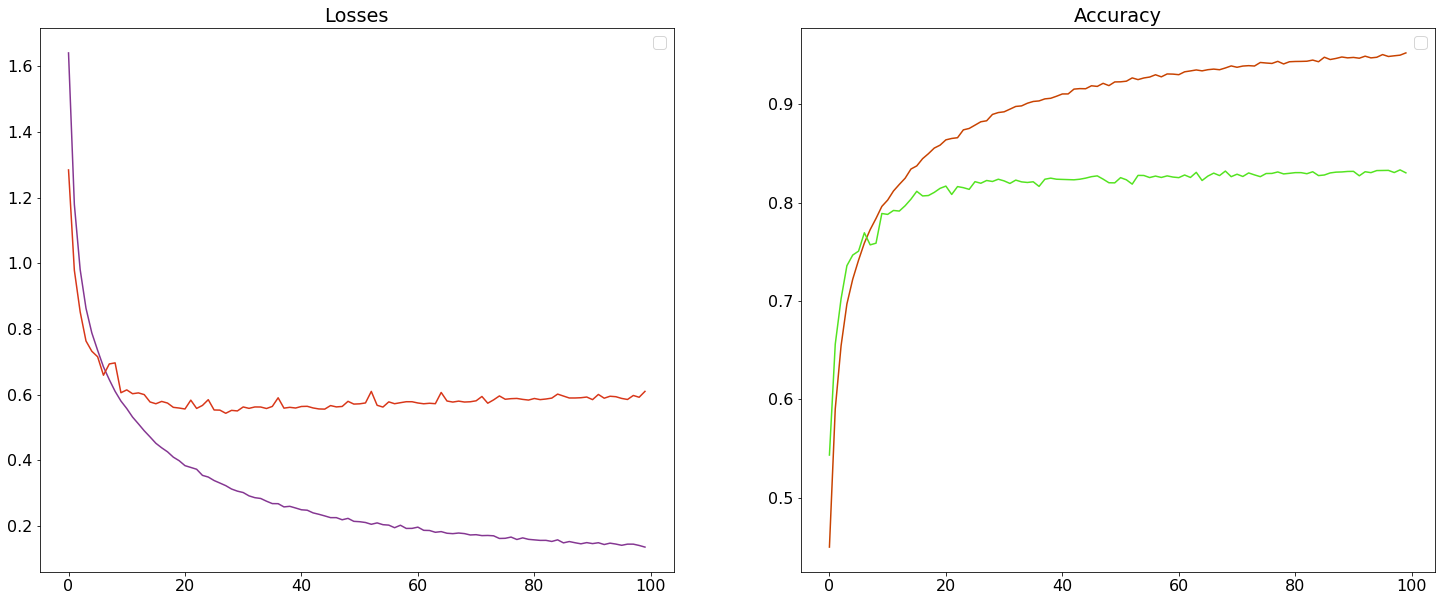

In [16]:
plt.figure(figsize=(25,10))
# update font size
plt.rcParams.update({'font.size': 16})

plt.subplot(121)
plt.title("Losses")
plt.legend(("Training losses", "Test losses"))
plt.plot(np.arange(0, num_epochs), loss_acc_dict["loss"], c="#853792")
plt.plot(np.arange(0, num_epochs), loss_acc_dict["val_loss"], c="#d8371a")

plt.subplot(122)
plt.title("Accuracy")
plt.legend(("Training Accuracy", "Test Accuracy"))
plt.plot(np.arange(0, num_epochs), loss_acc_dict["acc"], c="#c84301")
plt.plot(np.arange(0, num_epochs), loss_acc_dict["val_acc"], c="#54e321")

plt.show()

                            Classification report

In [17]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1000
           1       0.93      0.91      0.92      1000
           2       0.77      0.72      0.74      1000
           3       0.71      0.65      0.68      1000
           4       0.79      0.83      0.81      1000
           5       0.74      0.79      0.76      1000
           6       0.82      0.91      0.86      1000
           7       0.90      0.86      0.88      1000
           8       0.88      0.92      0.90      1000
           9       0.90      0.90      0.90      1000

   micro avg       0.83      0.83      0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



                            Confusion matrix

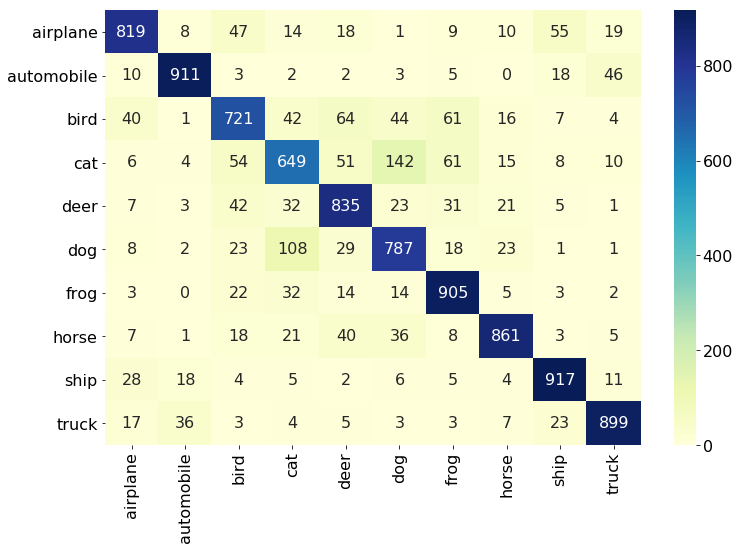

In [18]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
pd_cm = pd.DataFrame(cm, index=[l for l in label_encoder.values()], columns=[c for c in label_encoder.values()])

plt.figure(figsize=(12,8))
sn.heatmap(pd_cm, annot=True, cmap="YlGnBu", fmt='d')
plt.show()

                            Show images

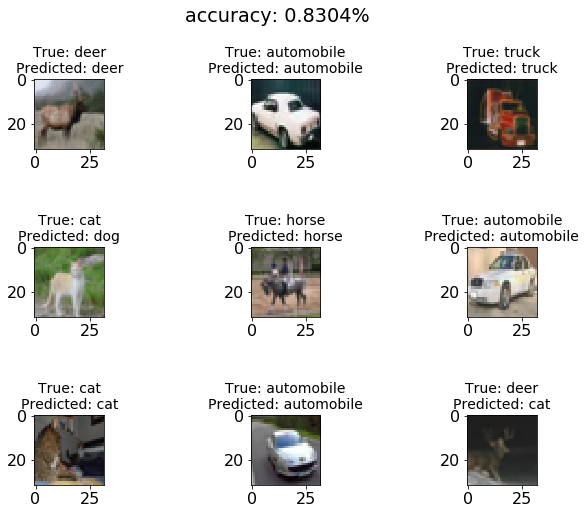

In [19]:
plot_images(label_encoder, (X_test, y_test.argmax(axis=1)), y_pred.argmax(axis=1))

## The same model without Batch normalization

In [20]:
model = Sequential()
# Conv layer with 32 filters
model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
# Conv layer with 32 filters
model.add(Conv2D(32, (3,3), padding="same"))
model.add(Activation("relu"))
# 2 x 2 max pooling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Conv layer with 64 filters
model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
# Conv layer with 64 filters
model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
# 2 x 2 max pooling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Fully-connected layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
# Output
model.add(Dropout(0.5))
model.add(Dense(10))

model.add(Activation("softmax"))

All hyperparameters (learning rate, number of epochs, etc.) are the same as for the network with batch normalization

In [21]:
start2_ckpt = datetime.now()

In [22]:
optimizer = SGD(lr=alpha, decay=0.00025, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)
train_history_no_bn = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=num_epochs)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 182us/step - loss: 1.8096 - acc: 0.3362 - val_loss: 1.4303 - val_acc: 0.4868
Epoch 2/100
50000/50000 [==============================] - 9s 177us/step - loss: 1.3574 - acc: 0.5070 - val_loss: 1.1561 - val_acc: 0.5876
Epoch 3/100
50000/50000 [==============================] - 9s 173us/step - loss: 1.1643 - acc: 0.5821 - val_loss: 1.0054 - val_acc: 0.6403
Epoch 4/100
50000/50000 [==============================] - 8s 169us/step - loss: 1.0417 - acc: 0.6301 - val_loss: 0.9401 - val_acc: 0.6719
Epoch 5/100
50000/50000 [==============================] - 8s 164us/step - loss: 0.9563 - acc: 0.6600 - val_loss: 0.8858 - val_acc: 0.6860
Epoch 6/100
50000/50000 [==============================] - 8s 164us/step - loss: 0.8847 - acc: 0.6860 - val_loss: 0.8089 - val_acc: 0.7167
Epoch 7/100
50000/50000 [==============================] - 8s 165us/step - loss: 0.8217 - acc: 0.7079 - val_loss: 0.

50000/50000 [==============================] - 8s 164us/step - loss: 0.1974 - acc: 0.9287 - val_loss: 0.6991 - val_acc: 0.8009
Epoch 60/100
50000/50000 [==============================] - 8s 162us/step - loss: 0.1919 - acc: 0.9305 - val_loss: 0.7061 - val_acc: 0.7998
Epoch 61/100
50000/50000 [==============================] - 9s 174us/step - loss: 0.1924 - acc: 0.9297 - val_loss: 0.6988 - val_acc: 0.8003
Epoch 62/100
50000/50000 [==============================] - 8s 163us/step - loss: 0.1871 - acc: 0.9324 - val_loss: 0.7019 - val_acc: 0.8005
Epoch 63/100
50000/50000 [==============================] - 8s 163us/step - loss: 0.1839 - acc: 0.9330 - val_loss: 0.6920 - val_acc: 0.8016
Epoch 64/100
50000/50000 [==============================] - 8s 167us/step - loss: 0.1843 - acc: 0.9339 - val_loss: 0.6897 - val_acc: 0.8050
Epoch 65/100
50000/50000 [==============================] - 9s 171us/step - loss: 0.1803 - acc: 0.9360 - val_loss: 0.7093 - val_acc: 0.8035
Epoch 66/100
50000/50000 [=======

In [23]:
second_ckpt = datetime.now()

In [24]:
loss_acc_dict = train_history_no_bn.history
y_pred_no_bn = model.predict(X_test, batch_size=batch_size)

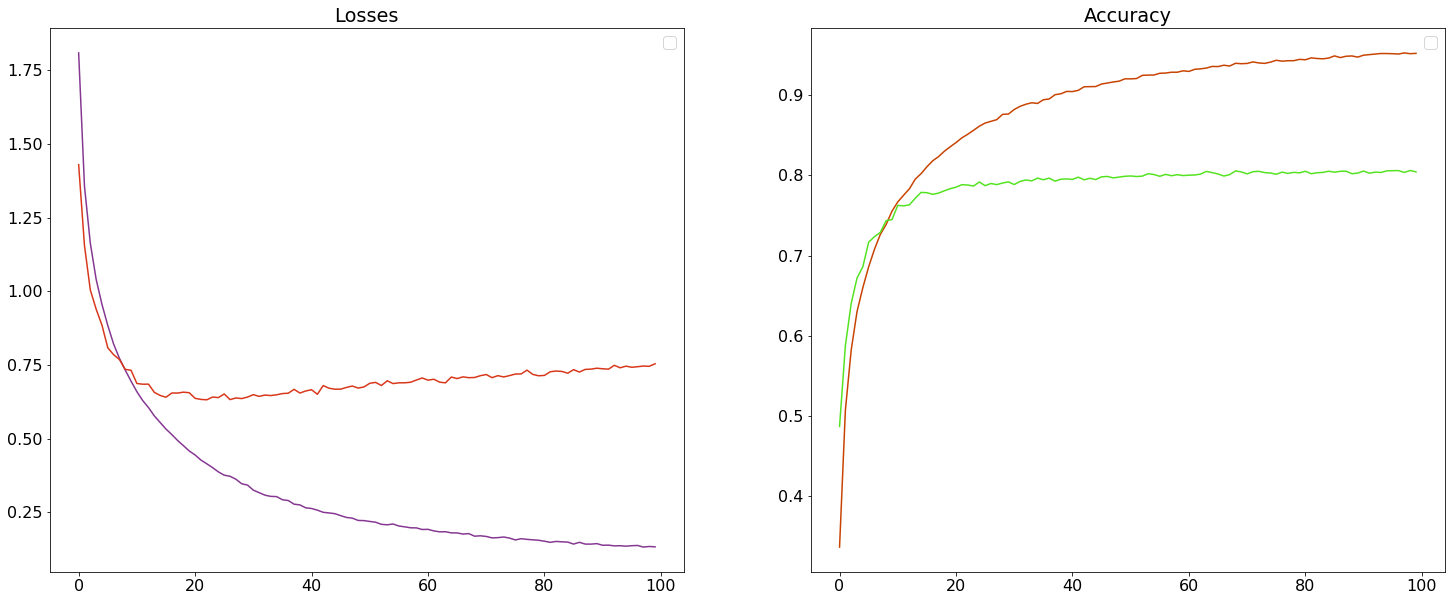

In [25]:
plt.figure(figsize=(25,10))
# update font size
plt.rcParams.update({'font.size': 16})

plt.subplot(121)
plt.title("Losses")
plt.legend(("Training losses", "Test losses"))
plt.plot(np.arange(0, num_epochs), loss_acc_dict["loss"], c="#853792")
plt.plot(np.arange(0, num_epochs), loss_acc_dict["val_loss"], c="#d8371a")

plt.subplot(122)
plt.title("Accuracy")
plt.legend(("Training Accuracy", "Test Accuracy"))
plt.plot(np.arange(0, num_epochs), loss_acc_dict["acc"], c="#c84301")
plt.plot(np.arange(0, num_epochs), loss_acc_dict["val_acc"], c="#54e321")

plt.show()

In [26]:
print(classification_report(y_test.argmax(axis=1), y_pred_no_bn.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1000
           1       0.90      0.89      0.90      1000
           2       0.78      0.68      0.73      1000
           3       0.64      0.62      0.63      1000
           4       0.74      0.78      0.76      1000
           5       0.71      0.74      0.72      1000
           6       0.80      0.90      0.84      1000
           7       0.86      0.83      0.85      1000
           8       0.89      0.89      0.89      1000
           9       0.87      0.88      0.88      1000

   micro avg       0.80      0.80      0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



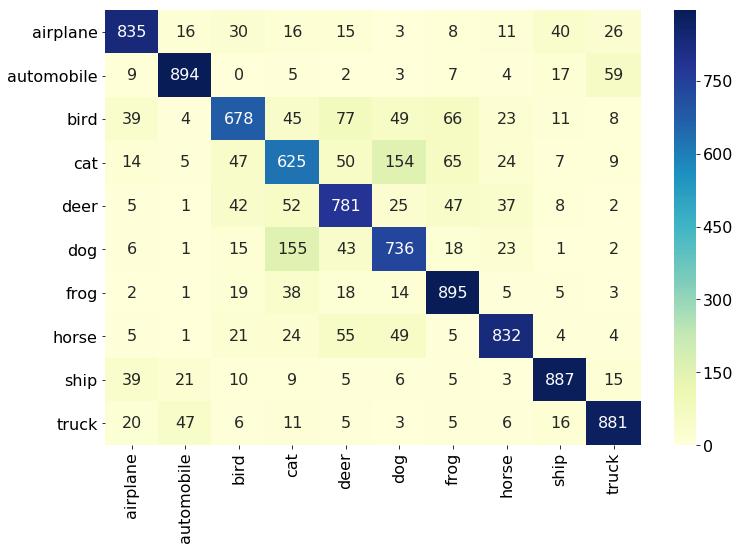

In [27]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_no_bn.argmax(axis=1))
pd_cm = pd.DataFrame(cm, index=[l for l in label_encoder.values()], columns=[c for c in label_encoder.values()])

plt.figure(figsize=(12,8))
sn.heatmap(pd_cm, annot=True, cmap="YlGnBu", fmt='d')
plt.show()

## Compare results with batch normalization and without it

Training time per epoch is 12s with BN vs 8-9s without BN

In [28]:
print(f'Number of epochs: {num_epochs}')
print(f'Accuracy with BN: {100*(y_pred.argmax(axis=1) == y_test.argmax(axis=1)).sum() / len(y_test)}%')
print(f'Accuracy without BN {100*(y_pred_no_bn.argmax(axis=1) == y_test.argmax(axis=1)).sum() / len(y_test)}%')
print(f'Duration of training with BN: {(first_ckpt - start_ckpt).seconds} seconds')
print(f'Duration of training with BN: {(second_ckpt - start2_ckpt).seconds} seconds')

Number of epochs: 100
Accuracy with BN: 83.04%
Accuracy without BN 80.44%
Duration of training with BN: 1185 seconds
Duration of training with BN: 836 seconds
